# Homework:
# Deep Convolutional Generative Adversarial Network 

Description of an implementation of DCGAN can be found in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

In [8]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [9]:
mnist = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=False)

Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [10]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

In [11]:
def generator(z):
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network

### Task1 (13 points)
Fill parameter for the discrimiator architecture

In [17]:
def discriminator(bottom, reuse=False):
    with slim.arg_scope([slim.fully_connected, slim.convolution2d], reuse=reuse, weights_initializer=initializer):
        dis1 = slim.convolution2d(bottom, scope='d_conv1', num_outputs=16,
                                  kernel_size=[5, 5], stride=[2, 2], padding="SAME", 
                                  activation_fn=lrelu)

        dis2 = slim.convolution2d(dis1, scope='d_conv2', num_outputs=32,
                                  kernel_size=[5, 5], stride=[2, 2], padding="SAME",
                                  normalizer_fn=slim.batch_norm, activation_fn=lrelu)

        dis3 = slim.convolution2d(dis2, scope='d_conv3', num_outputs=64,
                                  kernel_size=[5, 5], stride=[2, 2], padding="SAME",
                                  normalizer_fn=slim.batch_norm, activation_fn=lrelu)
        
        dis4 = slim.convolution2d(dis3, scope='d_conv4', num_outputs=128,
                                  kernel_size=[5, 5], stride=[2, 2], padding="SAME",
                                  normalizer_fn=slim.batch_norm, activation_fn=lrelu)
        
        d_out = slim.fully_connected(slim.flatten(dis4), scope='d_out', num_outputs=1,
                                     activation_fn=tf.nn.sigmoid)
                                     
    return d_out

### Connecting them together

In [18]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images


#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
I strongly advise you to skip this cell and go the the next one since training will take you enormous amount of time

In [20]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Gen Loss: 0.421173 Disc Loss: 1.58899
Gen Loss: 0.71384 Disc Loss: 1.56619
Gen Loss: 0.920782 Disc Loss: 1.20283
Gen Loss: 0.905117 Disc Loss: 1.46471
Gen Loss: 0.896863 Disc Loss: 1.38404
Gen Loss: 0.824423 Disc Loss: 1.27576
Gen Loss: 0.818525 Disc Loss: 1.30795
Gen Loss: 0.881535 Disc Loss: 1.18023
Gen Loss: 0.981922 Disc Loss: 1.24227
Gen Loss: 1.1612 Disc Loss: 1.19313
Gen Loss: 1.00271 Disc Loss: 1.31257
Gen Loss: 0.722971 Disc Loss: 1.43696
Gen Loss: 0.82019 Disc Loss: 1.21912
Gen Loss: 0.785617 Disc Loss: 1.38748
Gen Loss: 0.774676 Disc Loss: 1.45016
Gen Loss: 0.789035 Disc Loss: 1.40558
Gen Loss: 0.78036 Disc Loss: 1.34854
Gen Loss: 0.801892 Disc Loss: 1.28803
Gen Loss: 0.700462 Disc Loss: 1.39953
Gen Loss: 0.797109 Disc Loss: 1.42588
Gen Loss: 0.77171 Disc Loss: 1.32415
Gen Loss: 0.683627 Disc Loss: 1.34048
Gen Loss: 0.682396 Disc Loss: 1.39612
Gen Loss: 0.729551 Disc Loss: 1.32181
Gen Loss: 0.759256 Disc Loss: 1.36722
Gen Loss: 0.708899 Disc Loss: 1.3614
Gen Loss: 0.704857 D

Gen Loss: 0.649924 Disc Loss: 0.875598
Gen Loss: 0.341803 Disc Loss: 1.51202
Gen Loss: 0.436271 Disc Loss: 0.810727
Gen Loss: 1.0492 Disc Loss: 0.605379
Gen Loss: 0.382791 Disc Loss: 0.787422
Gen Loss: 1.09947 Disc Loss: 0.745067
Gen Loss: 0.227217 Disc Loss: 0.874247
Gen Loss: 0.718427 Disc Loss: 0.752374
Gen Loss: 0.35558 Disc Loss: 0.992604
Gen Loss: 0.455907 Disc Loss: 0.827573
Gen Loss: 1.09907 Disc Loss: 0.606864
Gen Loss: 0.575444 Disc Loss: 0.620478
Gen Loss: 1.15073 Disc Loss: 0.781414
Gen Loss: 0.917123 Disc Loss: 0.615335
Gen Loss: 0.883171 Disc Loss: 0.719759
Gen Loss: 0.905041 Disc Loss: 0.959182
Gen Loss: 0.656789 Disc Loss: 0.710766
Gen Loss: 0.515995 Disc Loss: 0.68963
Gen Loss: 0.909498 Disc Loss: 0.708872
Gen Loss: 1.24554 Disc Loss: 0.701825
Gen Loss: 1.02862 Disc Loss: 0.734583
Gen Loss: 0.994952 Disc Loss: 0.595574
Gen Loss: 0.490209 Disc Loss: 0.77109
Gen Loss: 0.622856 Disc Loss: 0.707865
Gen Loss: 0.856679 Disc Loss: 0.666622
Gen Loss: 0.649577 Disc Loss: 0.5161

Gen Loss: 0.221312 Disc Loss: 1.01499
Gen Loss: 0.830212 Disc Loss: 0.527397
Gen Loss: 2.04295 Disc Loss: 1.1276
Gen Loss: 0.889481 Disc Loss: 0.752082
Gen Loss: 0.758441 Disc Loss: 0.520068
Gen Loss: 0.238633 Disc Loss: 1.01907
Gen Loss: 0.720731 Disc Loss: 0.704333
Gen Loss: 0.62388 Disc Loss: 0.697891
Gen Loss: 0.565801 Disc Loss: 0.636671
Gen Loss: 0.444351 Disc Loss: 0.630116
Gen Loss: 0.690558 Disc Loss: 0.574461
Gen Loss: 0.689764 Disc Loss: 0.67035
Gen Loss: 0.605796 Disc Loss: 0.654711
Gen Loss: 0.388781 Disc Loss: 1.07323
Gen Loss: 0.510618 Disc Loss: 0.726183
Gen Loss: 0.493094 Disc Loss: 0.910389
Gen Loss: 0.224806 Disc Loss: 0.910964
Gen Loss: 2.04177 Disc Loss: 1.0419
Gen Loss: 1.09711 Disc Loss: 0.753824
Gen Loss: 0.88578 Disc Loss: 0.354215
Gen Loss: 1.40757 Disc Loss: 1.19709
Gen Loss: 0.323844 Disc Loss: 0.543829
Gen Loss: 0.53909 Disc Loss: 0.630531
Gen Loss: 0.320926 Disc Loss: 1.91621
Gen Loss: 0.825317 Disc Loss: 0.468535
Gen Loss: 1.27201 Disc Loss: 0.898503
Gen 

Gen Loss: 1.25639 Disc Loss: 0.849074
Gen Loss: 1.04874 Disc Loss: 0.705628
Gen Loss: 2.29574 Disc Loss: 1.1037
Gen Loss: 0.503619 Disc Loss: 0.609195
Gen Loss: 0.596541 Disc Loss: 1.16247
Gen Loss: 0.423092 Disc Loss: 0.889603
Gen Loss: 0.22441 Disc Loss: 0.903245
Gen Loss: 0.862229 Disc Loss: 0.864273
Gen Loss: 0.779809 Disc Loss: 0.485767
Gen Loss: 2.02524 Disc Loss: 0.864055
Gen Loss: 0.571641 Disc Loss: 0.901833
Gen Loss: 0.788323 Disc Loss: 0.89673
Gen Loss: 1.19349 Disc Loss: 0.734857
Gen Loss: 0.83959 Disc Loss: 0.58768
Gen Loss: 0.576898 Disc Loss: 0.677668
Gen Loss: 0.865474 Disc Loss: 0.65222
Gen Loss: 0.798522 Disc Loss: 0.355256
Gen Loss: 0.253318 Disc Loss: 0.79802
Gen Loss: 0.556141 Disc Loss: 0.469678
Gen Loss: 1.07387 Disc Loss: 1.00622
Gen Loss: 1.12138 Disc Loss: 0.711886
Gen Loss: 0.58591 Disc Loss: 0.787697
Gen Loss: 0.674602 Disc Loss: 0.645853
Gen Loss: 0.539154 Disc Loss: 0.580681
Gen Loss: 0.252673 Disc Loss: 0.822397
Gen Loss: 0.332434 Disc Loss: 0.802833
Gen 

Gen Loss: 0.644173 Disc Loss: 0.518123
Gen Loss: 0.239652 Disc Loss: 0.543413
Gen Loss: 1.10348 Disc Loss: 0.514452
Gen Loss: 0.697846 Disc Loss: 0.436926
Gen Loss: 0.528786 Disc Loss: 0.448557
Gen Loss: 0.555332 Disc Loss: 0.45207
Gen Loss: 0.262618 Disc Loss: 1.51687
Gen Loss: 0.570594 Disc Loss: 0.481098
Gen Loss: 0.319979 Disc Loss: 0.74742
Gen Loss: 0.897117 Disc Loss: 0.571109
Gen Loss: 0.589955 Disc Loss: 0.454741
Gen Loss: 0.301855 Disc Loss: 0.830102
Gen Loss: 1.41474 Disc Loss: 0.893103
Gen Loss: 0.397215 Disc Loss: 1.17961
Gen Loss: 0.191982 Disc Loss: 0.89645
Gen Loss: 0.769434 Disc Loss: 0.473456
Gen Loss: 0.255831 Disc Loss: 0.697413
Gen Loss: 0.627996 Disc Loss: 0.617312
Gen Loss: 0.296823 Disc Loss: 0.451164
Gen Loss: 1.30362 Disc Loss: 0.654888
Gen Loss: 0.594568 Disc Loss: 0.519412
Gen Loss: 1.13575 Disc Loss: 0.504819
Gen Loss: 0.158362 Disc Loss: 1.91585
Gen Loss: 0.648442 Disc Loss: 0.750286
Gen Loss: 0.803447 Disc Loss: 0.545415
Gen Loss: 0.263682 Disc Loss: 0.806

Gen Loss: 0.414186 Disc Loss: 0.582166
Gen Loss: 0.361978 Disc Loss: 0.708361
Gen Loss: 0.474728 Disc Loss: 0.412381
Gen Loss: 0.42443 Disc Loss: 0.36586
Gen Loss: 1.10572 Disc Loss: 0.41197
Gen Loss: 1.6208 Disc Loss: 0.864717
Gen Loss: 0.282807 Disc Loss: 0.720552
Gen Loss: 0.885132 Disc Loss: 0.537754
Gen Loss: 0.742851 Disc Loss: 0.439637
Gen Loss: 0.704873 Disc Loss: 0.277137
Gen Loss: 2.54254 Disc Loss: 1.77083
Gen Loss: 0.611677 Disc Loss: 0.448803
Gen Loss: 0.333495 Disc Loss: 0.642614
Gen Loss: 0.545255 Disc Loss: 0.835334
Gen Loss: 0.36543 Disc Loss: 0.799517
Gen Loss: 1.7472 Disc Loss: 0.575048
Gen Loss: 0.659918 Disc Loss: 0.274739
Gen Loss: 0.869976 Disc Loss: 0.812208
Gen Loss: 0.851617 Disc Loss: 0.537595
Gen Loss: 1.08562 Disc Loss: 0.757586
Gen Loss: 0.483421 Disc Loss: 0.529513
Gen Loss: 1.01567 Disc Loss: 0.586812
Gen Loss: 0.765861 Disc Loss: 0.768717
Gen Loss: 1.249 Disc Loss: 1.06163
Gen Loss: 0.348449 Disc Loss: 0.81488
Gen Loss: 0.867423 Disc Loss: 0.627462
Gen 

Gen Loss: 0.761769 Disc Loss: 0.556733
Gen Loss: 0.495682 Disc Loss: 0.304936
Gen Loss: 0.642994 Disc Loss: 0.478323
Gen Loss: 0.72773 Disc Loss: 0.360083
Gen Loss: 0.890308 Disc Loss: 0.670711
Gen Loss: 1.09289 Disc Loss: 0.487273
Gen Loss: 0.944047 Disc Loss: 0.432742
Gen Loss: 0.562496 Disc Loss: 0.488442
Gen Loss: 2.1726 Disc Loss: 1.66949
Gen Loss: 0.558215 Disc Loss: 0.413186
Gen Loss: 0.293358 Disc Loss: 0.366908
Gen Loss: 0.41614 Disc Loss: 0.389303
Gen Loss: 0.664743 Disc Loss: 0.554255
Gen Loss: 0.254131 Disc Loss: 0.378839
Gen Loss: 1.30809 Disc Loss: 0.45901
Gen Loss: 0.381788 Disc Loss: 0.481445
Gen Loss: 0.825442 Disc Loss: 0.293272
Gen Loss: 1.27239 Disc Loss: 0.426838
Gen Loss: 0.997864 Disc Loss: 0.622738
Gen Loss: 0.430681 Disc Loss: 0.546355
Gen Loss: 0.216005 Disc Loss: 0.724079
Saved Model
Gen Loss: 0.985318 Disc Loss: 0.715204
Gen Loss: 0.54755 Disc Loss: 0.411711
Gen Loss: 0.893423 Disc Loss: 0.444472
Gen Loss: 0.794423 Disc Loss: 0.726487
Gen Loss: 0.490684 Disc

Gen Loss: 0.463165 Disc Loss: 0.409211
Gen Loss: 1.24277 Disc Loss: 0.467978
Gen Loss: 0.61851 Disc Loss: 0.470014
Gen Loss: 0.978345 Disc Loss: 0.356087
Gen Loss: 0.725531 Disc Loss: 0.294447
Gen Loss: 0.2398 Disc Loss: 0.487752
Gen Loss: 0.224532 Disc Loss: 0.902652
Gen Loss: 0.909377 Disc Loss: 0.645563
Saved Model
Gen Loss: 0.733611 Disc Loss: 0.450589
Gen Loss: 0.879343 Disc Loss: 0.246244
Gen Loss: 1.09098 Disc Loss: 0.246583
Gen Loss: 1.05939 Disc Loss: 0.259485
Gen Loss: 1.24192 Disc Loss: 0.283042
Gen Loss: 0.923691 Disc Loss: 0.362057
Gen Loss: 0.397655 Disc Loss: 0.514507
Gen Loss: 1.24307 Disc Loss: 0.454935
Gen Loss: 2.68717 Disc Loss: 0.743287
Gen Loss: 1.86063 Disc Loss: 0.392165
Gen Loss: 1.24311 Disc Loss: 0.609562
Gen Loss: 0.51279 Disc Loss: 0.348755
Gen Loss: 0.287962 Disc Loss: 0.517116
Gen Loss: 0.663887 Disc Loss: 0.430899
Gen Loss: 0.27986 Disc Loss: 0.37659
Gen Loss: 0.500002 Disc Loss: 0.483148
Gen Loss: 0.753465 Disc Loss: 0.500692
Gen Loss: 2.21799 Disc Loss

Gen Loss: 0.851485 Disc Loss: 0.398145
Gen Loss: 1.25311 Disc Loss: 0.469292
Gen Loss: 0.624827 Disc Loss: 0.306713
Gen Loss: 0.208374 Disc Loss: 0.472662
Gen Loss: 0.547854 Disc Loss: 0.466691
Gen Loss: 0.690028 Disc Loss: 0.550466
Gen Loss: 0.503139 Disc Loss: 0.260121
Gen Loss: 0.730313 Disc Loss: 0.221689
Gen Loss: 0.62913 Disc Loss: 0.309687
Gen Loss: 0.4907 Disc Loss: 0.542276
Gen Loss: 0.689579 Disc Loss: 0.622788
Gen Loss: 0.52726 Disc Loss: 0.269273
Gen Loss: 0.983387 Disc Loss: 0.425493
Gen Loss: 0.372352 Disc Loss: 0.547099
Gen Loss: 0.406798 Disc Loss: 0.484204
Gen Loss: 0.844612 Disc Loss: 0.30125
Gen Loss: 0.428705 Disc Loss: 0.555009
Gen Loss: 0.377199 Disc Loss: 3.77691
Gen Loss: 1.07631 Disc Loss: 0.855589
Gen Loss: 0.83174 Disc Loss: 0.432584
Gen Loss: 0.405193 Disc Loss: 0.516012
Gen Loss: 0.583328 Disc Loss: 0.2798
Gen Loss: 0.241146 Disc Loss: 0.486629
Gen Loss: 0.984214 Disc Loss: 0.358228
Gen Loss: 0.202184 Disc Loss: 1.04657
Gen Loss: 0.462857 Disc Loss: 0.46234

Gen Loss: 1.03353 Disc Loss: 0.33639
Gen Loss: 1.77929 Disc Loss: 0.249348
Gen Loss: 0.218346 Disc Loss: 0.31162
Gen Loss: 0.307945 Disc Loss: 0.465434
Gen Loss: 0.272269 Disc Loss: 0.346179
Gen Loss: 0.538893 Disc Loss: 0.182182
Gen Loss: 0.987311 Disc Loss: 0.733514
Gen Loss: 0.748328 Disc Loss: 0.599429
Gen Loss: 0.448644 Disc Loss: 0.787113
Gen Loss: 0.806943 Disc Loss: 0.630904
Gen Loss: 1.32384 Disc Loss: 0.945797
Gen Loss: 0.730002 Disc Loss: 0.269584
Gen Loss: 0.60671 Disc Loss: 0.260234
Gen Loss: 3.49988 Disc Loss: 1.77276
Gen Loss: 0.969891 Disc Loss: 0.386686
Gen Loss: 0.124154 Disc Loss: 0.672705
Gen Loss: 1.29443 Disc Loss: 0.357512
Gen Loss: 0.434307 Disc Loss: 0.271667
Gen Loss: 0.174983 Disc Loss: 0.604227
Gen Loss: 0.65546 Disc Loss: 0.438357
Gen Loss: 0.438603 Disc Loss: 0.60383
Gen Loss: 0.209313 Disc Loss: 0.730373
Gen Loss: 0.232197 Disc Loss: 0.450268
Gen Loss: 0.525127 Disc Loss: 0.511928
Gen Loss: 0.839308 Disc Loss: 0.364772
Gen Loss: 0.859839 Disc Loss: 0.2964

Gen Loss: 0.291173 Disc Loss: 0.37533
Gen Loss: 0.711994 Disc Loss: 0.20401
Gen Loss: 0.573918 Disc Loss: 0.265158
Gen Loss: 0.700291 Disc Loss: 0.320722
Gen Loss: 0.488773 Disc Loss: 0.206184
Gen Loss: 0.631635 Disc Loss: 0.308524
Gen Loss: 0.760481 Disc Loss: 0.294907
Gen Loss: 0.951234 Disc Loss: 0.16496
Gen Loss: 0.468495 Disc Loss: 0.625488
Gen Loss: 1.24344 Disc Loss: 0.376177
Gen Loss: 0.384132 Disc Loss: 0.402964
Gen Loss: 0.541878 Disc Loss: 0.252493
Gen Loss: 0.743694 Disc Loss: 0.565916
Gen Loss: 1.55365 Disc Loss: 0.332573
Gen Loss: 0.487169 Disc Loss: 0.310146
Gen Loss: 0.682956 Disc Loss: 0.308544
Gen Loss: 0.937657 Disc Loss: 0.184688
Gen Loss: 1.24775 Disc Loss: 0.24122
Gen Loss: 1.0844 Disc Loss: 0.595427
Gen Loss: 0.801235 Disc Loss: 0.486908
Gen Loss: 0.41076 Disc Loss: 0.191745
Gen Loss: 0.494242 Disc Loss: 2.5369
Gen Loss: 0.637656 Disc Loss: 0.331436
Gen Loss: 0.536754 Disc Loss: 0.356792
Gen Loss: 0.767999 Disc Loss: 0.749587
Gen Loss: 0.459075 Disc Loss: 0.26124

Gen Loss: 0.185343 Disc Loss: 0.659037
Gen Loss: 1.31396 Disc Loss: 0.24966
Gen Loss: 2.51661 Disc Loss: 0.9735
Gen Loss: 0.913497 Disc Loss: 0.347288
Gen Loss: 0.342493 Disc Loss: 0.383188
Gen Loss: 0.173841 Disc Loss: 0.547098
Gen Loss: 0.383781 Disc Loss: 0.228013
Gen Loss: 2.43137 Disc Loss: 0.472399
Gen Loss: 1.0209 Disc Loss: 0.335973
Gen Loss: 0.812879 Disc Loss: 0.512809
Gen Loss: 0.17994 Disc Loss: 0.514309
Gen Loss: 0.26061 Disc Loss: 1.15603
Gen Loss: 0.618157 Disc Loss: 0.461674
Gen Loss: 1.31146 Disc Loss: 0.323479
Gen Loss: 0.533439 Disc Loss: 0.228641
Gen Loss: 1.01344 Disc Loss: 0.388983
Gen Loss: 1.22056 Disc Loss: 0.237744
Gen Loss: 0.711167 Disc Loss: 0.145018
Gen Loss: 1.60394 Disc Loss: 0.683901
Gen Loss: 0.493759 Disc Loss: 0.286929
Gen Loss: 1.27076 Disc Loss: 0.429471
Gen Loss: 0.737319 Disc Loss: 0.600599
Gen Loss: 1.48046 Disc Loss: 0.36232
Gen Loss: 0.967834 Disc Loss: 0.402023
Gen Loss: 0.562758 Disc Loss: 0.211235
Gen Loss: 0.14098 Disc Loss: 0.720053
Gen L

Gen Loss: 0.381318 Disc Loss: 0.32939
Gen Loss: 2.69279 Disc Loss: 0.826851
Gen Loss: 1.3169 Disc Loss: 0.689712
Gen Loss: 0.90256 Disc Loss: 0.293837
Gen Loss: 0.558324 Disc Loss: 0.541506
Gen Loss: 2.40123 Disc Loss: 0.630305
Gen Loss: 1.34312 Disc Loss: 0.257409
Gen Loss: 1.07142 Disc Loss: 0.163994
Gen Loss: 1.1796 Disc Loss: 0.435261
Gen Loss: 0.599731 Disc Loss: 0.199262
Gen Loss: 0.515862 Disc Loss: 1.88614
Gen Loss: 1.10345 Disc Loss: 0.417503
Gen Loss: 0.342933 Disc Loss: 0.408542
Gen Loss: 1.2046 Disc Loss: 0.374935
Gen Loss: 0.312451 Disc Loss: 0.365542
Gen Loss: 0.209517 Disc Loss: 0.483075
Gen Loss: 1.08216 Disc Loss: 0.328444
Gen Loss: 1.00172 Disc Loss: 0.252427
Gen Loss: 0.887784 Disc Loss: 0.317443
Gen Loss: 1.45874 Disc Loss: 0.907507
Gen Loss: 0.705094 Disc Loss: 0.192119
Gen Loss: 0.173285 Disc Loss: 0.563475
Gen Loss: 0.46438 Disc Loss: 0.230533
Gen Loss: 0.408698 Disc Loss: 0.404659
Gen Loss: 0.825634 Disc Loss: 0.521986
Gen Loss: 0.355559 Disc Loss: 0.183158
Gen 

Gen Loss: 1.07799 Disc Loss: 0.17128
Gen Loss: 0.535688 Disc Loss: 0.202393
Gen Loss: 0.349546 Disc Loss: 0.538758
Gen Loss: 0.378251 Disc Loss: 0.457402
Gen Loss: 0.882147 Disc Loss: 0.287637
Gen Loss: 0.262961 Disc Loss: 0.482138
Gen Loss: 1.20172 Disc Loss: 0.06995
Gen Loss: 0.43674 Disc Loss: 0.257692
Gen Loss: 0.419339 Disc Loss: 0.200843
Gen Loss: 1.28672 Disc Loss: 0.109575
Gen Loss: 2.0429 Disc Loss: 0.0597076
Gen Loss: 1.90334 Disc Loss: 0.337606
Gen Loss: 1.54537 Disc Loss: 0.367883
Gen Loss: 0.71301 Disc Loss: 0.143582
Gen Loss: 0.823026 Disc Loss: 0.106716
Gen Loss: 0.20734 Disc Loss: 0.396032
Gen Loss: 1.04487 Disc Loss: 0.231033
Gen Loss: 1.41748 Disc Loss: 0.193335
Gen Loss: 0.814502 Disc Loss: 0.189646
Gen Loss: 0.574124 Disc Loss: 0.134339
Gen Loss: 1.59864 Disc Loss: 0.443109
Gen Loss: 0.501238 Disc Loss: 0.149254
Gen Loss: 1.04671 Disc Loss: 0.495571
Gen Loss: 0.290371 Disc Loss: 0.271103
Gen Loss: 0.400033 Disc Loss: 0.279
Gen Loss: 1.15253 Disc Loss: 0.341716
Gen L

Gen Loss: 1.37491 Disc Loss: 0.183328
Gen Loss: 1.17851 Disc Loss: 0.0564241
Gen Loss: 0.347228 Disc Loss: 0.296449
Gen Loss: 1.05614 Disc Loss: 0.135165
Gen Loss: 0.332701 Disc Loss: 0.186738
Gen Loss: 0.560412 Disc Loss: 2.31718
Gen Loss: 0.884207 Disc Loss: 0.346757
Gen Loss: 1.45817 Disc Loss: 0.372804
Gen Loss: 2.50458 Disc Loss: 0.756333
Gen Loss: 0.661914 Disc Loss: 0.355151
Gen Loss: 1.79156 Disc Loss: 0.619429
Gen Loss: 0.886876 Disc Loss: 0.273516
Gen Loss: 0.440332 Disc Loss: 0.206251
Gen Loss: 2.00079 Disc Loss: 0.687887
Gen Loss: 0.606507 Disc Loss: 0.202304
Gen Loss: 0.177002 Disc Loss: 0.712112
Gen Loss: 0.640939 Disc Loss: 0.228565
Saved Model
Gen Loss: 0.782614 Disc Loss: 0.188526
Gen Loss: 0.263376 Disc Loss: 1.16994
Gen Loss: 0.701642 Disc Loss: 0.105119
Gen Loss: 1.41676 Disc Loss: 0.171991
Gen Loss: 0.309403 Disc Loss: 0.276298
Gen Loss: 0.672653 Disc Loss: 0.311143
Gen Loss: 0.678182 Disc Loss: 0.170356
Gen Loss: 1.35477 Disc Loss: 0.413764
Gen Loss: 0.566893 Disc

Gen Loss: 0.245719 Disc Loss: 0.561935
Gen Loss: 0.315585 Disc Loss: 0.16119
Gen Loss: 1.13814 Disc Loss: 0.496608
Gen Loss: 0.30971 Disc Loss: 0.319506
Gen Loss: 0.469405 Disc Loss: 0.145677
Saved Model
Gen Loss: 1.29876 Disc Loss: 0.329521
Gen Loss: 0.609377 Disc Loss: 0.623603
Gen Loss: 0.82108 Disc Loss: 0.207031
Gen Loss: 0.588111 Disc Loss: 0.351519
Gen Loss: 0.113 Disc Loss: 1.00828
Gen Loss: 0.883865 Disc Loss: 0.20423
Gen Loss: 0.867045 Disc Loss: 0.214258
Gen Loss: 1.1545 Disc Loss: 0.194218
Gen Loss: 1.21955 Disc Loss: 0.262288
Gen Loss: 0.891174 Disc Loss: 0.104472
Gen Loss: 1.06294 Disc Loss: 0.332539
Gen Loss: 0.371166 Disc Loss: 0.224712
Gen Loss: 0.543687 Disc Loss: 0.364285
Gen Loss: 0.299604 Disc Loss: 0.501957
Gen Loss: 0.381123 Disc Loss: 0.22024
Gen Loss: 0.564592 Disc Loss: 0.826186
Gen Loss: 0.843696 Disc Loss: 0.22721
Gen Loss: 0.274744 Disc Loss: 0.309443
Gen Loss: 0.368108 Disc Loss: 0.247344
Gen Loss: 1.54245 Disc Loss: 0.13394
Gen Loss: 0.68547 Disc Loss: 0.

Gen Loss: 0.290405 Disc Loss: 0.220636
Gen Loss: 0.905048 Disc Loss: 0.209127
Gen Loss: 0.538106 Disc Loss: 0.198732
Gen Loss: 0.435621 Disc Loss: 0.289306
Gen Loss: 0.500998 Disc Loss: 0.26088
Gen Loss: 2.43456 Disc Loss: 0.933395
Gen Loss: 1.20169 Disc Loss: 0.302037
Gen Loss: 0.320983 Disc Loss: 0.384325
Gen Loss: 1.70231 Disc Loss: 0.181392
Gen Loss: 0.608227 Disc Loss: 0.144737
Gen Loss: 0.258361 Disc Loss: 0.128896
Gen Loss: 0.422917 Disc Loss: 0.141117
Gen Loss: 0.611698 Disc Loss: 0.333658
Gen Loss: 1.4896 Disc Loss: 0.384301
Gen Loss: 1.24736 Disc Loss: 0.0924048
Gen Loss: 0.831431 Disc Loss: 0.153125
Gen Loss: 1.43668 Disc Loss: 0.190919
Gen Loss: 0.359639 Disc Loss: 0.338129
Gen Loss: 0.168513 Disc Loss: 0.311849
Gen Loss: 1.25619 Disc Loss: 0.449241
Gen Loss: 0.433875 Disc Loss: 0.167092
Gen Loss: 0.707659 Disc Loss: 0.223839
Gen Loss: 0.296998 Disc Loss: 0.278404
Gen Loss: 0.732579 Disc Loss: 0.346618
Gen Loss: 0.908893 Disc Loss: 0.121933
Gen Loss: 0.906794 Disc Loss: 0.0

Gen Loss: 1.18794 Disc Loss: 0.203276
Gen Loss: 0.887147 Disc Loss: 0.0734847
Gen Loss: 1.71418 Disc Loss: 0.479823
Gen Loss: 0.708508 Disc Loss: 0.110203
Gen Loss: 0.407373 Disc Loss: 0.252815
Gen Loss: 0.649017 Disc Loss: 0.160679
Gen Loss: 0.268144 Disc Loss: 0.330891
Gen Loss: 1.59998 Disc Loss: 0.476562
Gen Loss: 0.869328 Disc Loss: 0.176806
Gen Loss: 0.786301 Disc Loss: 0.247944
Gen Loss: 0.848553 Disc Loss: 0.0697437
Gen Loss: 0.70108 Disc Loss: 0.253876
Gen Loss: 0.362086 Disc Loss: 0.13743
Gen Loss: 0.310492 Disc Loss: 0.072971
Gen Loss: 0.818631 Disc Loss: 0.145625
Gen Loss: 0.770028 Disc Loss: 0.25976
Gen Loss: 2.49557 Disc Loss: 0.58109
Gen Loss: 0.991835 Disc Loss: 0.299247
Gen Loss: 0.583463 Disc Loss: 0.134663
Gen Loss: 0.48358 Disc Loss: 0.26478
Gen Loss: 0.725814 Disc Loss: 0.332517
Gen Loss: 0.984182 Disc Loss: 0.318106
Gen Loss: 0.23882 Disc Loss: 0.318187
Gen Loss: 0.619756 Disc Loss: 0.119177
Gen Loss: 0.860915 Disc Loss: 0.183719
Gen Loss: 1.51596 Disc Loss: 0.448

Gen Loss: 1.04542 Disc Loss: 0.0271352
Gen Loss: 0.762488 Disc Loss: 0.0767846
Gen Loss: 1.46759 Disc Loss: 0.2024
Gen Loss: 0.618385 Disc Loss: 0.320534
Gen Loss: 0.476836 Disc Loss: 0.234092
Gen Loss: 0.645822 Disc Loss: 0.405668
Gen Loss: 1.22521 Disc Loss: 0.0983511
Gen Loss: 0.4092 Disc Loss: 0.315225
Gen Loss: 4.38298 Disc Loss: 3.44766
Gen Loss: 0.671599 Disc Loss: 0.313441
Gen Loss: 0.858931 Disc Loss: 0.0986229
Gen Loss: 0.904985 Disc Loss: 0.0900145
Gen Loss: 0.707119 Disc Loss: 0.0814604
Gen Loss: 0.727368 Disc Loss: 0.286217
Gen Loss: 0.592347 Disc Loss: 0.123123
Gen Loss: 1.14366 Disc Loss: 0.108593
Gen Loss: 1.83471 Disc Loss: 0.229809
Gen Loss: 0.843688 Disc Loss: 0.0547964
Gen Loss: 0.632763 Disc Loss: 0.173152
Gen Loss: 1.00751 Disc Loss: 0.0315397
Gen Loss: 0.493276 Disc Loss: 0.146638
Gen Loss: 0.0601773 Disc Loss: 0.555927
Gen Loss: 0.547014 Disc Loss: 0.439858
Gen Loss: 2.03607 Disc Loss: 0.337615
Gen Loss: 1.08021 Disc Loss: 0.498633
Gen Loss: 0.908437 Disc Loss: 

Gen Loss: 0.585589 Disc Loss: 0.166298
Gen Loss: 1.77521 Disc Loss: 0.610775
Gen Loss: 1.73983 Disc Loss: 0.367158
Gen Loss: 0.814397 Disc Loss: 0.244576
Gen Loss: 0.421796 Disc Loss: 0.410138
Gen Loss: 1.10609 Disc Loss: 0.127742
Gen Loss: 1.36857 Disc Loss: 0.190333
Gen Loss: 0.765206 Disc Loss: 0.0778448
Gen Loss: 0.227278 Disc Loss: 0.577003
Gen Loss: 0.131579 Disc Loss: 0.460071
Gen Loss: 0.640252 Disc Loss: 0.184519
Gen Loss: 0.879689 Disc Loss: 0.125708
Gen Loss: 0.391029 Disc Loss: 0.258452
Gen Loss: 0.496967 Disc Loss: 0.175154
Gen Loss: 0.951733 Disc Loss: 0.123286
Gen Loss: 0.134385 Disc Loss: 0.332311
Gen Loss: 3.29176 Disc Loss: 0.607373
Gen Loss: 1.4298 Disc Loss: 0.228744
Gen Loss: 1.48454 Disc Loss: 0.25822
Gen Loss: 0.565076 Disc Loss: 0.115024
Gen Loss: 0.422167 Disc Loss: 0.234454
Gen Loss: 0.350492 Disc Loss: 0.964351
Gen Loss: 0.962907 Disc Loss: 0.116262
Gen Loss: 0.708332 Disc Loss: 0.166501
Gen Loss: 0.984853 Disc Loss: 0.13415
Gen Loss: 0.577044 Disc Loss: 0.14

Gen Loss: 0.85668 Disc Loss: 0.0593535
Gen Loss: 4.59358 Disc Loss: 0.993515
Gen Loss: 0.424337 Disc Loss: 0.113485
Gen Loss: 0.834317 Disc Loss: 0.119893
Gen Loss: 0.372302 Disc Loss: 0.5737
Gen Loss: 0.630245 Disc Loss: 0.199412
Gen Loss: 0.19719 Disc Loss: 0.202572
Gen Loss: 0.841136 Disc Loss: 0.0656158
Gen Loss: 0.389277 Disc Loss: 0.231239
Gen Loss: 0.435327 Disc Loss: 0.115948
Gen Loss: 0.346015 Disc Loss: 0.146587
Gen Loss: 0.245424 Disc Loss: 0.59041
Gen Loss: 0.55041 Disc Loss: 0.15432
Gen Loss: 0.290861 Disc Loss: 0.618149
Gen Loss: 0.68839 Disc Loss: 0.113942
Gen Loss: 0.410208 Disc Loss: 0.165134
Gen Loss: 0.420748 Disc Loss: 0.65363
Gen Loss: 0.698214 Disc Loss: 0.222154
Gen Loss: 0.507981 Disc Loss: 0.148462
Gen Loss: 0.5278 Disc Loss: 0.0807843
Gen Loss: 0.485535 Disc Loss: 0.117937
Gen Loss: 1.37488 Disc Loss: 0.36442
Gen Loss: 0.860062 Disc Loss: 0.131642
Gen Loss: 0.542152 Disc Loss: 0.180434
Gen Loss: 0.506306 Disc Loss: 0.304663
Gen Loss: 2.82769 Disc Loss: 0.55929

Gen Loss: 0.526084 Disc Loss: 0.125301
Gen Loss: 0.53226 Disc Loss: 0.136762
Gen Loss: 1.07115 Disc Loss: 0.0781183
Gen Loss: 0.43308 Disc Loss: 0.150876
Gen Loss: 0.975429 Disc Loss: 0.048457
Gen Loss: 0.732036 Disc Loss: 0.10808
Gen Loss: 0.669996 Disc Loss: 0.0649606
Gen Loss: 0.637397 Disc Loss: 0.103306
Gen Loss: 0.707217 Disc Loss: 0.0549763
Gen Loss: 0.243147 Disc Loss: 0.15
Gen Loss: 1.10133 Disc Loss: 0.0383828
Gen Loss: 1.40302 Disc Loss: 0.0563411
Gen Loss: 1.16273 Disc Loss: 0.0424612
Gen Loss: 0.549258 Disc Loss: 0.0371168
Gen Loss: 0.227822 Disc Loss: 1.17472
Gen Loss: 2.8898 Disc Loss: 0.731494
Gen Loss: 0.375241 Disc Loss: 0.423102
Gen Loss: 3.41596 Disc Loss: 1.10209
Gen Loss: 0.677208 Disc Loss: 0.126319
Gen Loss: 0.727239 Disc Loss: 0.253826
Gen Loss: 0.297382 Disc Loss: 0.166708
Gen Loss: 0.198921 Disc Loss: 0.136008
Gen Loss: 0.56825 Disc Loss: 0.0800016
Gen Loss: 0.513015 Disc Loss: 0.0517339
Gen Loss: 0.466201 Disc Loss: 0.177936
Gen Loss: 0.820658 Disc Loss: 0.0

Gen Loss: 1.55518 Disc Loss: 0.24244
Gen Loss: 0.551313 Disc Loss: 0.0981862
Gen Loss: 0.707324 Disc Loss: 0.0631034
Gen Loss: 0.808749 Disc Loss: 0.204403
Gen Loss: 0.387912 Disc Loss: 0.149397
Gen Loss: 1.06573 Disc Loss: 0.0276421
Gen Loss: 0.482506 Disc Loss: 0.124033
Gen Loss: 0.251238 Disc Loss: 0.0896562
Gen Loss: 0.836537 Disc Loss: 0.0600767
Gen Loss: 2.18953 Disc Loss: 0.369139
Gen Loss: 0.238279 Disc Loss: 1.20235
Gen Loss: 1.42767 Disc Loss: 0.28637
Gen Loss: 0.641529 Disc Loss: 0.300373
Gen Loss: 0.553865 Disc Loss: 0.107556
Gen Loss: 0.493861 Disc Loss: 0.114557
Gen Loss: 0.685396 Disc Loss: 0.193098
Gen Loss: 0.694402 Disc Loss: 0.141795
Gen Loss: 0.855512 Disc Loss: 0.344945
Gen Loss: 0.88889 Disc Loss: 0.182919
Gen Loss: 0.39798 Disc Loss: 0.314556
Gen Loss: 0.0725628 Disc Loss: 0.47891
Saved Model
Gen Loss: 0.0805717 Disc Loss: 1.0261
Gen Loss: 1.43206 Disc Loss: 0.444218
Gen Loss: 0.275577 Disc Loss: 0.608148
Gen Loss: 1.61384 Disc Loss: 0.752331
Gen Loss: 2.98693 Di

Gen Loss: 0.228362 Disc Loss: 0.360263
Gen Loss: 1.00489 Disc Loss: 0.129942
Gen Loss: 0.599576 Disc Loss: 0.208195
Gen Loss: 0.54748 Disc Loss: 0.10127
Gen Loss: 0.605916 Disc Loss: 0.0866698
Gen Loss: 0.666582 Disc Loss: 0.0673183
Gen Loss: 0.686634 Disc Loss: 0.0705833
Gen Loss: 1.85499 Disc Loss: 0.100715
Gen Loss: 0.419785 Disc Loss: 0.838879
Saved Model
Gen Loss: 0.708909 Disc Loss: 0.0904973
Gen Loss: 0.478756 Disc Loss: 0.714106
Gen Loss: 1.02659 Disc Loss: 0.101357
Gen Loss: 1.438 Disc Loss: 0.162597
Gen Loss: 0.139416 Disc Loss: 0.830307
Gen Loss: 0.948348 Disc Loss: 0.257825
Gen Loss: 0.143418 Disc Loss: 0.681638
Gen Loss: 0.58947 Disc Loss: 0.134611
Gen Loss: 0.525576 Disc Loss: 0.430535
Gen Loss: 1.00062 Disc Loss: 0.32827
Gen Loss: 0.526594 Disc Loss: 0.0383033
Gen Loss: 0.642727 Disc Loss: 0.170649
Gen Loss: 0.87946 Disc Loss: 0.208015
Gen Loss: 0.761972 Disc Loss: 0.0765744
Gen Loss: 0.421631 Disc Loss: 0.0510636
Gen Loss: 0.243679 Disc Loss: 0.0865897
Gen Loss: 1.27228

Gen Loss: 1.17842 Disc Loss: 0.069119
Gen Loss: 1.3071 Disc Loss: 0.0252469
Gen Loss: 0.482336 Disc Loss: 0.0883375
Gen Loss: 0.134715 Disc Loss: 0.25383
Gen Loss: 0.313182 Disc Loss: 0.164517
Gen Loss: 0.965364 Disc Loss: 0.00905485
Gen Loss: 3.45562 Disc Loss: 0.969423
Gen Loss: 2.37393 Disc Loss: 0.634585
Gen Loss: 0.443823 Disc Loss: 0.0553272
Gen Loss: 0.75051 Disc Loss: 0.0661205
Gen Loss: 0.544697 Disc Loss: 0.0965552
Gen Loss: 1.04971 Disc Loss: 0.477951
Gen Loss: 1.2584 Disc Loss: 0.123659
Gen Loss: 0.866546 Disc Loss: 0.15388
Gen Loss: 1.19602 Disc Loss: 0.107273
Gen Loss: 0.591656 Disc Loss: 0.206438
Gen Loss: 0.691398 Disc Loss: 0.163904
Gen Loss: 0.299571 Disc Loss: 0.0434047
Gen Loss: 0.797428 Disc Loss: 0.183033
Gen Loss: 0.836095 Disc Loss: 0.038815
Gen Loss: 2.72869 Disc Loss: 0.601156
Gen Loss: 0.712131 Disc Loss: 0.184957
Gen Loss: 0.625311 Disc Loss: 0.155592
Gen Loss: 1.20815 Disc Loss: 0.0820964
Gen Loss: 0.733967 Disc Loss: 0.109852
Gen Loss: 1.16554 Disc Loss: 0

Gen Loss: 0.719114 Disc Loss: 0.115772
Gen Loss: 0.22586 Disc Loss: 0.305176
Gen Loss: 0.70763 Disc Loss: 0.140616
Gen Loss: 0.955739 Disc Loss: 0.0351445
Gen Loss: 1.31584 Disc Loss: 0.345662
Gen Loss: 0.199091 Disc Loss: 0.126376
Gen Loss: 0.343295 Disc Loss: 0.309783
Gen Loss: 1.21566 Disc Loss: 0.117291
Gen Loss: 0.209307 Disc Loss: 0.305338
Gen Loss: 0.182291 Disc Loss: 0.102155
Gen Loss: 0.594807 Disc Loss: 0.103364
Gen Loss: 0.241726 Disc Loss: 0.295381
Gen Loss: 0.114139 Disc Loss: 0.386868
Gen Loss: 0.860525 Disc Loss: 0.200929
Gen Loss: 0.893766 Disc Loss: 0.747084
Gen Loss: 0.692691 Disc Loss: 0.956337
Gen Loss: 1.05031 Disc Loss: 0.093322
Gen Loss: 0.833587 Disc Loss: 0.258194
Gen Loss: 0.714633 Disc Loss: 0.391842
Gen Loss: 0.884626 Disc Loss: 0.0505725
Gen Loss: 0.221502 Disc Loss: 0.272436
Gen Loss: 0.765585 Disc Loss: 0.253378
Gen Loss: 1.51213 Disc Loss: 0.255546
Gen Loss: 0.249327 Disc Loss: 0.461568
Gen Loss: 0.805126 Disc Loss: 0.147604
Gen Loss: 0.523513 Disc Loss:

Gen Loss: 1.63164 Disc Loss: 0.472332
Gen Loss: 1.18483 Disc Loss: 0.0330328
Gen Loss: 1.33337 Disc Loss: 0.122586
Gen Loss: 1.0249 Disc Loss: 0.111582
Gen Loss: 0.758834 Disc Loss: 0.198401
Gen Loss: 0.747374 Disc Loss: 0.17038
Gen Loss: 0.374688 Disc Loss: 0.0360619
Gen Loss: 0.764831 Disc Loss: 0.193452
Gen Loss: 0.352353 Disc Loss: 0.144588
Gen Loss: 0.103338 Disc Loss: 0.179022
Gen Loss: 0.0804883 Disc Loss: 1.34596
Gen Loss: 0.977143 Disc Loss: 0.217259
Gen Loss: 0.479929 Disc Loss: 0.301504
Gen Loss: 0.475883 Disc Loss: 0.265262
Gen Loss: 1.77703 Disc Loss: 0.217309
Gen Loss: 0.975275 Disc Loss: 0.0777574
Gen Loss: 2.30041 Disc Loss: 0.298912
Gen Loss: 0.539305 Disc Loss: 0.220979
Gen Loss: 0.717451 Disc Loss: 0.126137
Gen Loss: 2.47039 Disc Loss: 0.636066
Gen Loss: 1.02226 Disc Loss: 0.151313
Gen Loss: 0.62888 Disc Loss: 0.274654
Gen Loss: 0.369046 Disc Loss: 0.0738784
Gen Loss: 0.838427 Disc Loss: 0.170661
Gen Loss: 0.60577 Disc Loss: 0.0813428
Gen Loss: 0.575308 Disc Loss: 0.

Gen Loss: 0.699615 Disc Loss: 0.0512758
Gen Loss: 0.572494 Disc Loss: 0.0340558
Gen Loss: 1.48309 Disc Loss: 0.0550131
Gen Loss: 0.955787 Disc Loss: 0.197439
Gen Loss: 0.518172 Disc Loss: 0.557229
Gen Loss: 0.709696 Disc Loss: 0.0953358
Gen Loss: 0.979767 Disc Loss: 0.170866
Gen Loss: 0.536223 Disc Loss: 0.0523981
Gen Loss: 0.866797 Disc Loss: 0.0704653
Gen Loss: 0.321157 Disc Loss: 0.185518
Gen Loss: 0.259636 Disc Loss: 0.0770652
Gen Loss: 1.09727 Disc Loss: 0.249732
Gen Loss: 0.600717 Disc Loss: 0.084933
Gen Loss: 1.16927 Disc Loss: 0.0651007
Gen Loss: 0.243046 Disc Loss: 0.0977734
Gen Loss: 1.98333 Disc Loss: 0.196014
Gen Loss: 2.07071 Disc Loss: 0.225238
Gen Loss: 0.446807 Disc Loss: 0.58732
Gen Loss: 0.869376 Disc Loss: 0.0883159
Gen Loss: 0.200193 Disc Loss: 0.313526
Gen Loss: 0.545439 Disc Loss: 0.0521825
Gen Loss: 0.471879 Disc Loss: 0.628084
Gen Loss: 0.778348 Disc Loss: 0.200713
Gen Loss: 1.15626 Disc Loss: 0.0628129
Gen Loss: 0.478834 Disc Loss: 0.0934761
Gen Loss: 0.519453 

KeyboardInterrupt: 

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [26]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

path = model_directory  + '/model-58000.cptk'

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    saver.restore(sess, save_path=path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig.png')

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-58000.cptk


### Task 2 (2 points)
Run a couple of iterations and visualize examples generated by the generator (Could be found in ./fig folder)

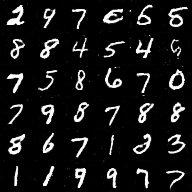

In [27]:
from IPython.display import Image
Image(filename='figs/fig.png') 

### Task 3 (5 points)
Evaluate discrimator accuracy in the pre-trained model on any representative subsample of fashion-minst

In [45]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 1000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    saver.restore(sess, save_path=path)
    
    cnt_rght = 0
    cnt_wrng = 0
    
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.test.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        
        
        dx, dg = sess.run([Dx, Dg],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        
        for j in range(len(dx)):
            if dx[j] > 0.1:
                cnt_rght += 1
            else:
                cnt_wrng += 1
        
        for j in range(len(dg)):
            if dg[j] < 0.1:
                cnt_rght += 1
            else:
                cnt_wrng += 1
        
        if i % 100 == 0:
            print("accuracy = ", cnt_rght/(cnt_rght + cnt_wrng))

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-58000.cptk
accuracy =  0.984375
accuracy =  0.8642868193069307
accuracy =  0.8640780472636815
accuracy =  0.8715220099667774
accuracy =  0.8708015118453866
accuracy =  0.8678892215568862
accuracy =  0.8688188955906821
accuracy =  0.8688870809557775
accuracy =  0.8699672284644194
accuracy =  0.869134121809101
